In [2]:
import numpy as np
import tensorflow as tf
import keras as keras
import matplotlib.pyplot as plt

In [3]:
# define problem parameters
n = 270
N = 1024
k = 40

num_layers = 15

# define number of training/validation/testing samples
num_train_samples = 75000
num_valid_samples = 25000
num_test_samples = 25000
total_num_samples = num_train_samples + num_valid_samples + num_test_samples

# use default rng
rng = np.random.default_rng()

# system parameters
dual_bs = True
fading = True
noise = True
cmplx = True ## changing this to False won't do anything
snr_dB = [-12, -10, -5, 1, 5, 10, 20]
num_layers = 15

# Training

In [ ]:
# defining functions
def tf_cmplx_eta(u,T):
  return tf.math.exp(tf.complex(0.0,tf.math.angle(u))) * tf.complex(tf.math.maximum(tf.math.abs(u)-T, 0),0.0)

class CRF_LISTALayer(keras.layers.Layer):
  
  # defining variables for the layer
  def __init__(self, A, L, init_alpha, Q, W):
    super().__init__()
    self.A = A
    self.L = L
    self.n, self.N = self.A.shape
    self.alpha = tf.Variable(initial_value=init_alpha, dtype='float32', trainable=True)
    self.Q = tf.Variable(initial_value=init_Q, dtype='complex64', trainable=True)
    self.W = tf.Variable(initial_value=init_W, dtype='complex64', trainable=True)

  # creating inputs and updating things on each call
  def call(self, inputs):
    xHt = inputs[:, 0:self.N]
    y = inputs[:, self.N:]
    update = xHt @ self.Q + y @ self.W
    new_x = tf_cmplx_eta(update, self.alpha/self.L)  # this is what makes it differ from other LISTA layer
    return tf.concat([new_x, y], axis=1)

class CustomMSELoss(keras.losses.Loss):

  def __init__(self, N):
    super().__init__()
    self.N = N
  
  def call(self, true, pred):
    x_true = true[:, 0:self.N]
    x_pred = pred[:, 0:self.N]
    return tf.reduce_mean(tf.math.squared_difference(tf.complex(x_true,0.0), x_pred))
    #return tf.reduce_mean(tf.square(tf.abs(tf.complex(x_true,0.0) - x_pred)))
  
class CustomMSEMetric(keras.metrics.Mean):

  def __init__(self, N):
    super().__init__()
    self.N = N

  def update_state(self, true, pred, sample_weight=None):
    x_true = true[:, 0:self.N]
    x_pred = pred[:, 0:self.N]
    val = tf.reduce_mean(tf.math.squared_difference(tf.complex(x_true,0.0), x_pred))
    #val = tf.reduce_mean(tf.square(tf.abs(tf.complex(x_true,0.0) - x_pred)))
    return super().update_state(val, sample_weight=None)

In [ ]:
for snrdb in snr_dB:
    # data set has stacked A's and y's if dual_bs
    if dual_bs:
      # create sensing matrix A - will stack so energy of col of A = 1/2
      A = np.sqrt(1/(4*n))*np.random.randn(n, N) + 1j*np.sqrt(1/(4*n))*np.random.randn(n, N)  
    else:
      A = np.sqrt(1/(2*n))*np.random.randn(n, N) + 1j*np.sqrt(1/(2*n))*np.random.randn(n, N)  
      
    if fading:
      h1 = np.sqrt(1/2)*np.random.randn(N) + 1j*np.sqrt(1/2)*np.random.randn(N) 
      h1 = np.diag(h1) 
      
      A1 = A @ h1

      if dual_bs:
        # now stack and make one A
        h2 = np.sqrt(1/2)*np.random.randn(N) + 1j*np.sqrt(1/2)*np.random.randn(N) 
        h2 = np.diag(h2) 
        
        A2 = A @ h2
        A = np.vstack((A1, A2))
      else:
        A = A1
        
    elif dual_bs: # no fading, 2 BS
      # A is just stacked with itself if no fading -- will get overwritten if fading
      A = np.vstack((A,A))
      


    # creates the appropiate sigma
    if dual_bs:
      snr = (10**(snrdb/10))*2*n
    else:
      snr = (10**(snrdb/10))*n
    sigma = 1/(np.sqrt(snr))


    # noise vectors
    w1 = []
    for i in range(total_num_samples):
      w1.append(np.sqrt((sigma**2)/2) * np.random.randn(n) + 1j*np.sqrt((sigma**2)/2) * np.random.randn(n))
    w1 = np.array(w1)

    if dual_bs:
      w2 = []
      for i in range(total_num_samples):
        w2.append(np.sqrt((sigma**2)/2) * np.random.randn(n) + 1j*np.sqrt((sigma**2)/2) * np.random.randn(n))
      w2 = np.array(w2)
      # stack the noise
      w = np.hstack((w1,w2))
    else:
      w = w1

    # inital alpha value
    init_alpha = 0.3

    # creating initial values for trainable parameters
    _, Lambda, _ = np.linalg.svd(A)
    L = np.max(Lambda) + 1

    init_Q = np.eye(N) - (A.T @ A) / L
    init_W = A / L

    # create data
    x = np.zeros((total_num_samples, N))
    idx_nonzero = rng.permuted(np.tile(np.arange(N), (total_num_samples, 1)), axis=1)
    for i in range(k):
      x[np.arange(total_num_samples), idx_nonzero[:, i].flatten()] = 1

      
    if noise:
      y = x @ A.T + w  # adding noise here
    else:
      y = x @ A.T
    y = np.hstack((np.zeros((total_num_samples, N)), y))

    # Divide data into training, validation, testing sets
    train_data = y[0:num_train_samples, :]
    train_labels = x[0:num_train_samples, :]
    valid_data = y[num_train_samples:num_train_samples+num_valid_samples, :]
    valid_labels = x[num_train_samples:num_train_samples+num_valid_samples, :]
    test_data = y[num_train_samples+num_valid_samples:, :]
    test_labels = x[num_train_samples+num_valid_samples:, :]
 ########################################################
    lista_mse_cmplx = []
    learn_rate = .0001
    op = keras.optimizers.Adam(learning_rate=learn_rate)

    #epoch_nums = [20,20,20,20,20,20,22,25,28,31,34,40,43,46,50]
    epochs = 50

    if dual_bs:
    # create initial input -- shape is now (2n + N)
        input = keras.layers.Input(shape=(2*n+N,), name='y_inputs',dtype='complex64')
    else:
        input = keras.layers.Input(shape=(n+N,), name='y_inputs',dtype='complex64')

    for idx_layer in range(num_layers):
      # calls the layer differently depending on what layer it is 
        if idx_layer == 0:
          x_hidden = CRF_LISTALayer(A, L, init_alpha, init_Q, init_W) (input)
        elif idx_layer == num_layers - 1:  # output is populated on the last layer
          output = CRF_LISTALayer(A, L, init_alpha, init_Q, init_W) (x_hidden)
        else:
          x_hidden = CRF_LISTALayer(A, L, init_alpha, init_Q, init_W) (x_hidden)


    model = keras.Model(inputs=input, outputs=output, name='CRF_LISTAModel')
    # compile keras model
    custom_mse_loss = CustomMSELoss(N)
    custom_mse_metric = CustomMSEMetric(N)
    model.compile(optimizer=op, loss=custom_mse_loss, metrics=[custom_mse_metric])

    # train model
    history = model.fit(train_data,
                train_labels,
                batch_size=128,
                epochs=epochs,
                validation_data=(valid_data, valid_labels))

    results = model.evaluate(test_data, test_labels)
    lista_mse_cmplx.append(results[0])
    print(f'Final MSE on test data: {results[0]}')

    ## find MD, FA ##
    print('writing to files')
    xHt = model.predict(test_data)
    np.save('2bs_snr'+str(snrdb)+'dB_mdfa_predictions.npy', xHt)

    x = test_labels
    np.save('2bs_snr'+str(snrdb)+'dB_mdfa_labels.npy',x)
    print('file writing done')


Epoch 1/50
586/586 [==============================] - 20s 19ms/step - loss: 0.7212 - mean: 0.7211 - val_loss: 0.0516 - val_mean: 0.0516
Epoch 2/50
586/586 [==============================] - 10s 17ms/step - loss: 0.0346 - mean: 0.0346 - val_loss: 0.0256 - val_mean: 0.0256
Epoch 3/50
586/586 [==============================] - 10s 17ms/step - loss: 0.0211 - mean: 0.0211 - val_loss: 0.0187 - val_mean: 0.0187
Epoch 4/50
586/586 [==============================] - 10s 17ms/step - loss: 0.0165 - mean: 0.0165 - val_loss: 0.0158 - val_mean: 0.0158
Epoch 5/50
586/586 [==============================] - 10s 17ms/step - loss: 0.0143 - mean: 0.0143 - val_loss: 0.0141 - val_mean: 0.0141
Epoch 6/50
586/586 [==============================] - 10s 17ms/step - loss: 0.0129 - mean: 0.0129 - val_loss: 0.0130 - val_mean: 0.0130
Epoch 7/50
586/586 [==============================] - 10s 17ms/step - loss: 0.0120 - mean: 0.0120 - val_loss: 0.0123 - val_mean: 0.0123
Epoch 8/50
586/586 [============================

# MD, FA

In [ ]:
!cp '2bs_snr-12dB_mdfa_predictions.npy' /content/drive/MyDrive/Research
!cp '2bs_snr-12dB_mdfa_labels.npy' /content/drive/MyDrive/Research

In [4]:
# determining threshold based on 24,900 test samples
test_to = 24900
thresholds = np.arange(.1,1,.05)

for threshold in thresholds:
  avg_fa = []
  avg_md = []
  for snrdb in snr_dB:
    # load in data from the files
    # xHt = np.load('2bs_snr'+str(snrdb)+'dB_mdfa_predictions.npy')
    name = "/content/drive/MyDrive/Research/2bs_snr"+str(snrdb)+"dB_mdfa_predictions.npy"
    xHt = np.load(name)
    xHt = xHt.T[:N,:]
    xHt = xHt.T
    label = '/content/drive/MyDrive/Research/2bs_snr'+str(snrdb)+'dB_mdfa_labels.npy'
    labels = np.load(label)

    # find the avg MD FA
    fa_ar = np.zeros(test_to)
    md_ar = np.zeros(test_to)
    for i in range(test_to):
        user_guess = np.where(abs(xHt[i]) > threshold)
        real_users = np.where(abs(labels[i]) == 1)
        # print(f'user_guess: {user_guess}')
        # print(f'real: {real_users}')
        fa_ar[i] = len(np.setdiff1d(user_guess, real_users))
        md_ar[i] = len(np.setdiff1d(real_users, user_guess))
    # find the avg
    avg_fa.append(sum(fa_ar) / test_to)
    avg_md.append(sum(md_ar) / test_to)
  print(f'Threshold: {threshold}')
  print(f'FA: {avg_fa}')
  print(f'MD: {avg_md}')

Threshold: 0.1
FA: [10.706184738955823, 7.035863453815261, 1.620562248995984, 0.5329317269076306, 0.13658634538152611, 0.05164658634538152, 0.05397590361445783]
MD: [1.829839357429719, 0.9695582329317269, 0.07542168674698795, 0.02855421686746988, 0.0008433734939759036, 0.0, 0.0024096385542168677]
Threshold: 0.15000000000000002
FA: [7.082329317269076, 4.463413654618474, 0.8473092369477911, 0.24911646586345382, 0.04863453815261044, 0.013534136546184738, 0.017791164658634537]
MD: [2.1894779116465863, 1.1813253012048193, 0.101285140562249, 0.038795180722891565, 0.0017269076305220883, 0.0, 0.004497991967871486]
Threshold: 0.20000000000000004
FA: [4.814939759036145, 2.9366265060240964, 0.4727710843373494, 0.12164658634538153, 0.018714859437751002, 0.0034538152610441766, 0.006345381526104418]
MD: [2.5970682730923693, 1.425301204819277, 0.1355421686746988, 0.05096385542168675, 0.0026104417670682733, 0.0, 0.007911646586345382]
Threshold: 0.25000000000000006
FA: [3.32285140562249, 1.969678714859

In [5]:
threshold = .45  # change me based on results above

avg_fa =[]
avg_md=[]
# now test on the remaining 100 samples
for snrdb in snr_dB:
  name = "/content/drive/MyDrive/Research/2bs_snr"+str(snrdb)+"dB_mdfa_predictions.npy"
  xHt = np.load(name)
  xHt = xHt.T[:N,:]
  xHt = xHt.T
  label = '/content/drive/MyDrive/Research/2bs_snr'+str(snrdb)+'dB_mdfa_labels.npy'
  labels = np.load(label)

  # find the avg MD FA
  fa_ar = np.zeros(100)
  md_ar = np.zeros(100)
  cnt=0
  for i in range(test_to, num_test_samples):
    user_guess = np.where(abs(xHt[i]) > threshold)
    real_users = np.where(abs(labels[i]) == 1)
    fa_ar[cnt] = len(np.setdiff1d(user_guess, real_users))
    md_ar[cnt] = len(np.setdiff1d(real_users, user_guess))
    cnt+=1
  # find the avg
  avg_fa.append(sum(fa_ar) / 100)
  avg_md.append(sum(md_ar) / 100)

print(f'Threshold: {threshold}')
print(f'FA: {avg_fa}')
print(f'MD: {avg_md}')

Threshold: 0.45
FA: [0.78, 0.39, 0.04, 0.01, 0.0, 0.0, 0.0]
MD: [5.76, 3.69, 0.65, 0.12, 0.0, 0.01, 0.06]


2 BS. CRF. threshold: 0.8


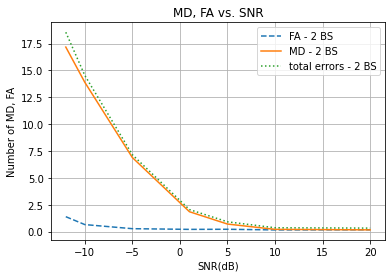

In [ ]:
# plot the results
total_er =[]
for i in range(len(avg_fa)):
  total_er.append(avg_fa[i] + avg_md[i])
print(f"2 BS. CRF. threshold: {threshold}")
plt.figure()
plt.plot(snr_dB, avg_fa, label="FA - 2 BS", linestyle="dashed")
plt.plot(snr_dB, avg_md, label="MD - 2 BS")
plt.plot(snr_dB, total_er, label='total errors - 2 BS', linestyle='dotted')
plt.legend()
plt.title("MD, FA vs. SNR")
plt.xlabel("SNR(dB)")
plt.ylabel("Number of MD, FA")
plt.grid(True, which ='both')
plt.show()

In [ ]:
print(f'FA: {avg_fa}')
print(f'MD: {avg_md}')

FA: [1.3806, 0.6454, 0.26368, 0.19968, 0.20888, 0.14884, 0.16292]
MD: [17.17332, 13.89032, 6.88492, 1.84348, 0.69424, 0.20204, 0.15432]


In [4]:
for snrdb in snr_dB:
  cnt = 0
  # load in data from the files
  name = "/content/drive/MyDrive/Research/2bs_snr"+str(snrdb)+"dB_mdfa_predictions.npy"
  xHt = np.load(name)
  
  for i in range(num_test_samples):
    cnt += len(np.where(abs(xHt[i])!=0))
  print(f'SNR: {snrdb}', end=" ")
  print(cnt)

SNR: -12 25000
SNR: -10 25000
SNR: -5 25000
SNR: 1 25000
SNR: 5 25000
SNR: 10 25000
SNR: 20 25000


In [ ]:
xHt = np.load('2bs_snr-10dB_mdfa_predictions.npy')
labels = np.load('2bs_snr-10dB_mdfa_labels.npy')
for elm in range(len(xHt[6])-1):
  if xHt[6][elm] != 0 and labels[6][elm] != 0:
    print(f'xHT: {abs(xHt[6][elm])}')
    print(f'x: {abs(labels[6][elm])}')
  

xHT: 1.0869171619415283
x: 1.0
xHT: 0.4645974040031433
x: 1.0
xHT: 1.0864770412445068
x: 1.0
xHT: 0.9816107749938965
x: 1.0
xHT: 0.9946898221969604
x: 1.0
xHT: 1.0476610660552979
x: 1.0
xHT: 0.8737512230873108
x: 1.0
xHT: 0.7667049169540405
x: 1.0
xHT: 0.7084980010986328
x: 1.0
xHT: 1.097817063331604
x: 1.0
xHT: 0.9668179750442505
x: 1.0
xHT: 0.8027741312980652
x: 1.0
xHT: 0.6940854787826538
x: 1.0
xHT: 0.8723172545433044
x: 1.0
xHT: 0.4168062210083008
x: 1.0
xHT: 1.0143219232559204
x: 1.0
xHT: 1.0996824502944946
x: 1.0
xHT: 0.06346434354782104
x: 1.0
xHT: 1.0880072116851807
x: 1.0
xHT: 0.7190245985984802
x: 1.0
xHT: 1.0463718175888062
x: 1.0
xHT: 1.2471866607666016
x: 1.0
xHT: 1.2560244798660278
x: 1.0
xHT: 0.9082379341125488
x: 1.0
xHT: 0.31492286920547485
x: 1.0
xHT: 1.0275596380233765
x: 1.0
xHT: 0.8204786777496338
x: 1.0
xHT: 0.9176888465881348
x: 1.0
xHT: 0.9241503477096558
x: 1.0
xHT: 1.415587067604065
x: 1.0
xHT: 0.3831958770751953
x: 1.0
xHT: 0.7402455806732178
x: 1.0
xHT: 0.9

IndexError: ignored